In [26]:
import clustertools as cts
import numpy as np
import time
import numba

In [17]:
def energies(cluster, specific=True, i_d=None, full=True, projected=False, parallel=False):
    """Calculate kinetic and potential energy of every star

    Parameters
    ----------
    cluster : class
      StarCluster instance
    specific : bool
      find specific energies (default: True)
    i_d : int
      if given, find energies for a specific star only (default: None)
    full : bool
      calculate distance of full array of stars at once with numbra (default: True)
    parallel : bool
      calculate distances in parallel (default: False)

    Returns
    -------
    ek,pot : float
      kinetic and potential energy of every star

    History
    -------
       2019 - Written - Webb (UofT)
    """
    cluster.save_cluster()
    units0,origin0, rorder0, rorder_origin0 = cluster.units0,cluster.origin0, cluster.rorder0, cluster.rorder_origin0

    if cluster.origin0 != 'cluster' and cluster.origin0 != 'centre':
        cluster.to_cluster(sortstars=False)

    grav=_get_grav(cluster)

    if projected:
      if specific:
          ek = 0.5 * (cluster.vpro ** 2.0)
      else:
          ek = 0.5 * cluster.m * (cluster.vpro ** 2.0)
    else:

      if specific:
          ek = 0.5 * (cluster.v ** 2.0)
      else:
          ek = 0.5 * cluster.m * (cluster.v ** 2.0)

    if i_d != None:
        indx = cluster.id == i_d

        dx = cluster.x[indx] - cluster.x
        dy = cluster.y[indx] - cluster.y
        dz = cluster.z[indx] - cluster.z

        if specific:
            m = cluster.m
        else:
            m = cluter.m[indx] * cluster.m

        if projected:
          dr = np.sqrt(dx ** 2.0 + dy ** 2.0)
        else:
          dr = np.sqrt(dx ** 2.0 + dy ** 2.0 + dz ** 2.0)

        rindx = dr != 0.0
        gmr = -grav * m[rindx] / dr[rindx]

        pot = np.sum(gmr)
        ek = ek[indx]
        etot = ek + pot

    elif full:
        if projected:
          x = np.array([cluster.x, cluster.y, np.zeros(len(cluster.x)), cluster.m]).T
        else:
          x = np.array([cluster.x, cluster.y, cluster.z, cluster.m]).T
        if parallel:
            pot = grav * np.array(_potential_energy_parallel(x))
        else:
            pot = grav * np.array(_potential_energy(x))

        if specific:
            pot /= cluster.m
    else:
        pot = []

        for i in range(0, cluster.ntot):
            dx = cluster.x[i] - cluster.x
            dy = cluster.y[i] - cluster.y
            dz = cluster.z[i] - cluster.z
            if specific:
                m = cluster.m
            else:
                m = cluter.m[i] * cluster.m

            if projected:
              dr = np.sqrt(dx ** 2.0 + dy ** 2.0)
            else:
              dr = np.sqrt(dx ** 2.0 + dy ** 2.0 + dz ** 2.0)

            indx = dr != 0.0
            gmr = -grav * m[indx] / dr[indx]

            pot.append(np.sum(gmr))

    cluster.return_cluster(units0,origin0, rorder0, rorder_origin0)


    return ek, pot

def _potential_energy(cluster):
    """Find potential energy for each star in a cluster
    - uses numba

    Parameters
    ----------
    cluster : class
        StarCluster

    Returns
    -------
        pot : float
            potential energy of every star

    History
    -------
       2019 - Written - Webb (UofT)
    """
    pot = [0.0] * len(cluster)
    for i in range(len(cluster) - 1):
        for j in range(i + 1, len(cluster)):
            r = distance(cluster[i], cluster[j])
            if r==0: print(i,j,r)
            m2 = cluster[i, 3] * cluster[j, 3]
            pot[i] += -m2 / r
            pot[j] += -m2 / r

    return pot

def _potential_energy_parallel(cluster):
    """Find potential energy for each star in a cluster in parallel
    - uses numba

    Parameters
    ----------
    cluster : class
        StarCluster

    Returns
    -------
        pot : float
            potential energy of every star

    History
    -------
       2019 - Written - Webb (UofT)
    """
    pot = [0.0] * len(cluster)
    for i in numba.prange(len(cluster) - 1):
        for j in range(i + 1, len(cluster)):
            r = distance(cluster[i], cluster[j])
            m2 = cluster[i, 3] * cluster[j, 3]
            pot[i] += -m2 / r
            pot[j] += -m2 / r

    return pot

def distance(x1, x2):
    """Find distance between two points (made for use with numba)

    Parameters
    ----------
    x1 : float
      3D position of first point of the form [x,y,z]
    x2 : float
      3D position of first point of the form [x,y,z]

    Returns
    -------
    distance : float
      distance between the two points

    History
    -------
    2019 - Written - Webb (UofT)
    """
    dx = x2[0] - x1[0]
    dy = x2[1] - x1[1]
    dz = x2[2] - x1[2]

    r = (dx * dx + dy * dy + dz * dz) ** 0.5

    return r

def _get_grav(cluster):
    if cluster.units == "nbody":
        grav = 1.0
    elif cluster.units == "pckms":
        # G has units of pc (km/s)^2 / Msun
        grav = 4.302e-3
    elif cluster.units == "kpckms":
        # G has units of kpc (km/s)^2 / Msun
        grav = 4.302e-6
    else:
        grav = 1.0

    return grav

In [18]:
cluster=cts.load_cluster(ctype='limepy',gcname='Pal5',N=100000)

LOAD_CLUSTER MADE USE OF:
Gieles, M. & Zocchi, A. 2015, MNRAS, 454, 576
Vasiliev E., 2019, MNRAS, 484,2832 
de Boer, T. J. L., Gieles, M., Balbinot, E., Hénault-Brunet, V., Sollima, A., Watkins, L. L., Claydon, I. 2019, MNRAS, 485, 4906


In [19]:
cluster.to_centre()
cluster.to_pckms()

0

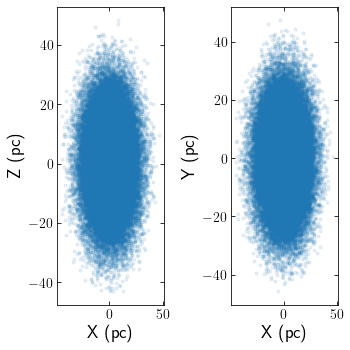

In [20]:
cts.starplot(cluster)

In [27]:
ti=time.time()
cluster.energies()
print(time.time()-ti)

29.546454668045044


In [22]:
ti=time.time()
energies(cluster)
print(time.time()-ti)

KeyboardInterrupt: 

In [28]:
ti=time.time()
cluster.energies(parallel=True)
print(time.time()-ti)

4.099106073379517
